<a href="https://colab.research.google.com/github/rautnavnath/Data-Science-Machine-Learning-Projects/blob/main/Mining_Trucks_predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction.
This Project aims to predict engine failures using RNN and LSTM networks for time-dependent variables.


Problem statement: Predict if an engine will fail within a particular cycle, given its history of cycles and sensory data. <br>

* Mining Equipments are very sensitive to the faults in their engines.
* Because of this, it is imperative to keep them in good condition to achieve desired productivity
* Mining Equipments are very expensive and so is their maintenance.
* But at the same time, we do not want to overdo the maintenance aspect.
* If we do not detect a fault in time, it might become too expensive to maintain/repair the engines, or they might have to be replaced


The content of the notebooks are as below.
1. importing libs<br>
2. Load the Dataset <br>
3. Data Preprocessing<br>
    3.1. Generating the classification target variable<br>
    3.2. Normalizing the data set<br>
4.Exploratory Data Analysis - EDA<br>
5. Generating Input Sequence<br>
6. RNN Models<br>
    6.1 Simple RNN [25 Features] <br>
    6.2  Bi-Directional RNN [25 Features] <br>
7. Model Building with LSTM <br>
8. References

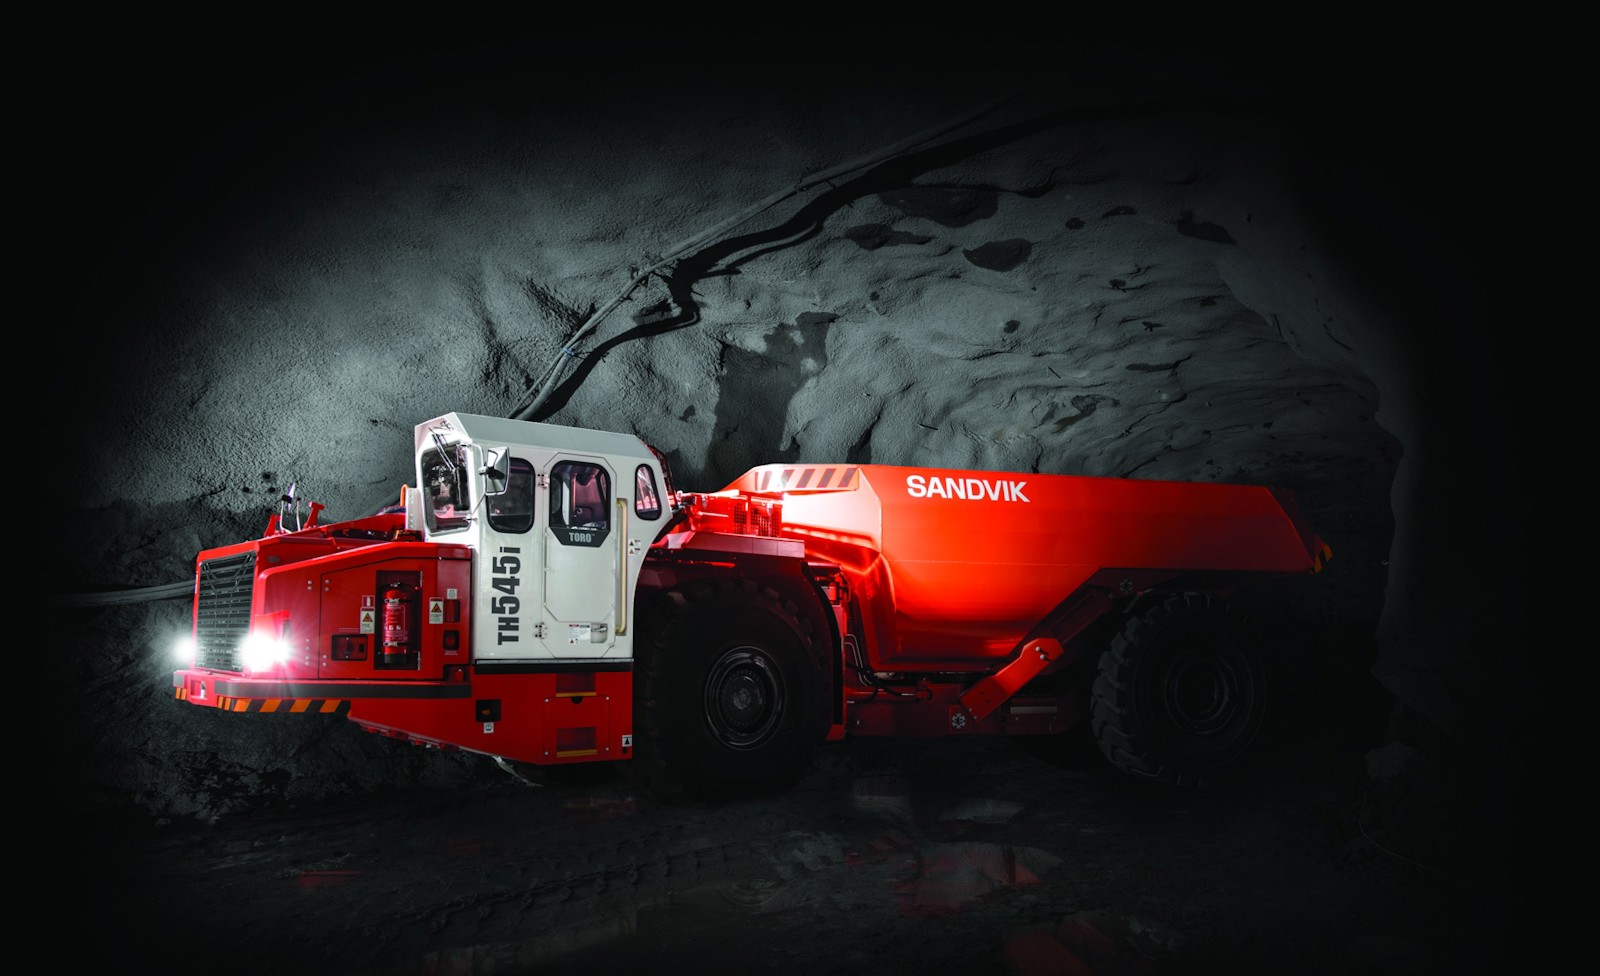

# 1. Importing libraries

In [10]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

In [11]:
#seed for reproducibility.
np.random.seed(42)
PYTHONHASHSEED = 0

# 2. Load the Dataset

In [13]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('/content/PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('/content/PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [14]:
# Let's drop the NAN columns 26 and 27 using the dropna() method.
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [15]:
print(len(train_df))
print(len(test_df))

20631
13096


In [16]:
cols_names = ['id', 'Hrs', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,Hrs,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [17]:
test_df.head(2)

,id,Hrs,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


In [18]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('/content/gtruth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [19]:
# We wil drop the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


# 3. Data Preprocessing
We will do the following while preprocessing the training dataset:

1. Generating the classification target variable
2. Normalizing the data set

## 3.1 Generating Classification Target Variable
In our scenario, mining machines operate continuously, often running 24x7. The challenge we face is how to predict machine failures in this context.

Specifically, in this use case where machines run non-stop, we aim to forecast breakdowns and associate them with unique IDs denoted as '1' in the target variable named 'failure_within_w1.'

In this context, 'w1' represents 'window_1,' which, in our case, corresponds to a 24-hour period.

####Importantly, we need to predict machine failures well in advance. To achieve this, we focus on determining the number of hours preceding a machine breakdown. We refer to this time frame as the 'window,' which can be set to various values like 1, 8, 24, or 48 hours, depending on how early we want to detect maintenance needs and the level of accuracy we require.

####For this particular scenario, we assume a window size of 24 hours, with the aim of identifying maintenance requirements one day in advance.



Sort the data set by id and Hrs so each engine can have its values sorted and stored in one place. We use the sort_values()


In [20]:
# method and specify which columns are to be considered while sorting using the parameter.

train_df.sort_values(['id','Hrs'], inplace=True)
test_df.sort_values(['id','Hrs'], inplace=True)

First, we find the Number of Hrs each engine run before breakdown in past using groupby() and then merge these values for respective engine data using merge().

Then, we calculate the remaining useful life (RUL) by subtracting the current Hr value from the max. For example, a Machine has a total life of 192 Hrs, and it has already run 50 Hrs; hence, its RUL will be 192-50 = 142.



In [21]:
# Extract the maximum number of Hrs Run for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['Hrs'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['Hrs']

#The RUL is calculated for each id.
train_df[['id','Hrs','max','RUL']].head()

,id,Hrs,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [22]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

Generate label column for training data

In [23]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 24
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

## 3.2 Normalize Training Dataset

In [24]:
# Make a separate feature for the normalized value of the Hrs column.
train_df['Hrs_norm'] = train_df['Hrs']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','Hrs','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','Hrs','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,Hrs,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,Hrs_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Normalize the test data in the same manner that you normalized the training data.

In [25]:
# We will perform MinMax normalization (from 0 to 1)
test_df['Hrs_norm'] = test_df['Hrs']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Label the test set like we did for the training data.

In [26]:
# Let's calculate the total RUL by summing up the maximum Hrs given in the test set and the
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['Hrs'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Hrs']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,Hrs,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,Hrs_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


# 4. Exploratory Data Analysis - EDA
Let's see how the sensor values change for a particular engine id, say id=1.


<Axes: >

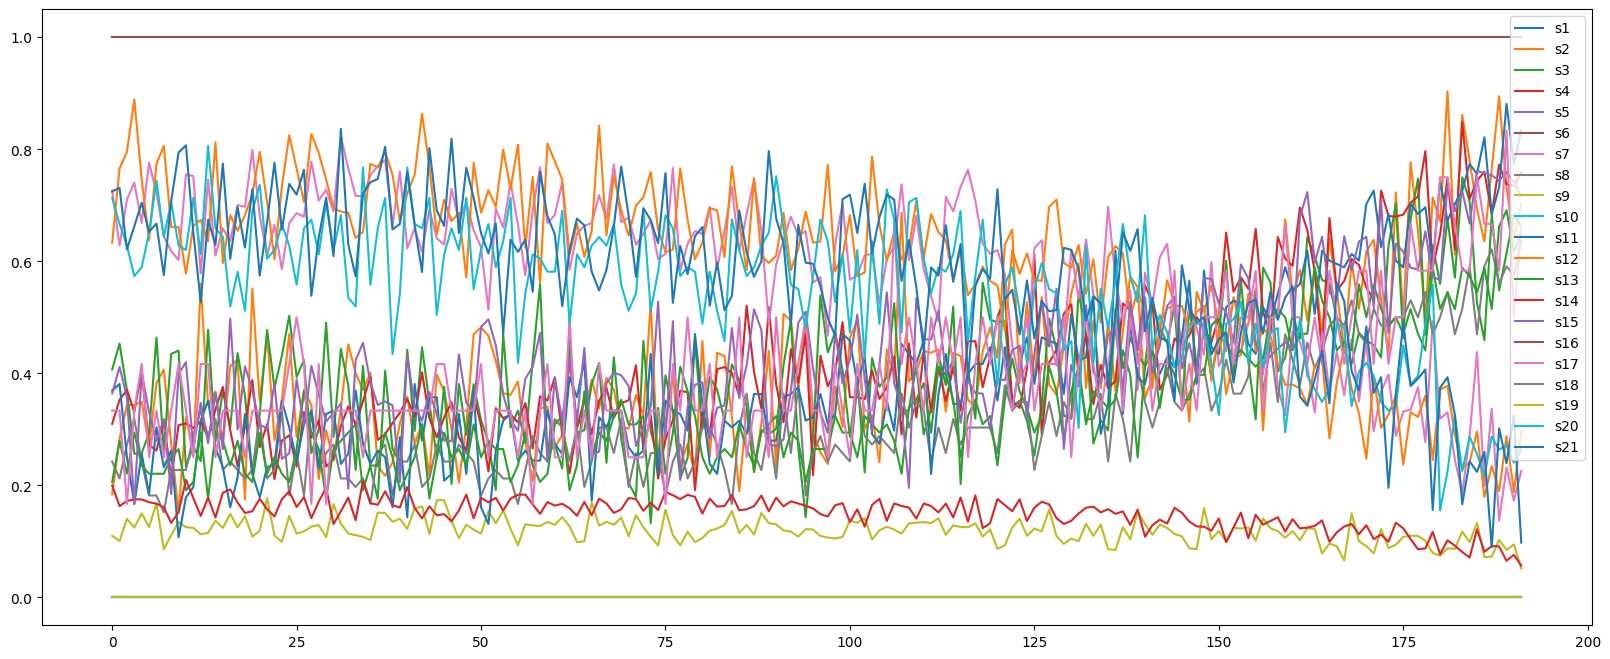

In [27]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<Axes: >

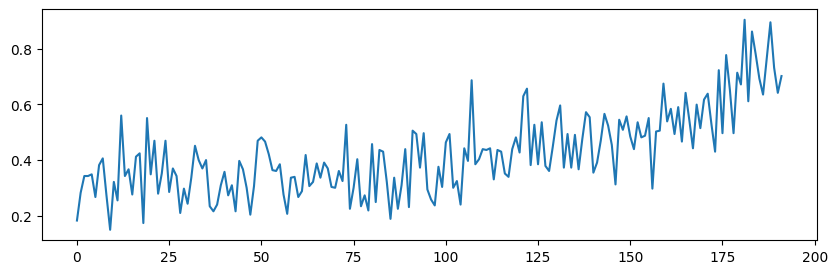

In [28]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

* Sensor 1 values increase as time progresses
* Sensor 6 values decrease as the time progresses
* Most other sensors exhibit either an increasing or decreasing trend.


<Axes: >

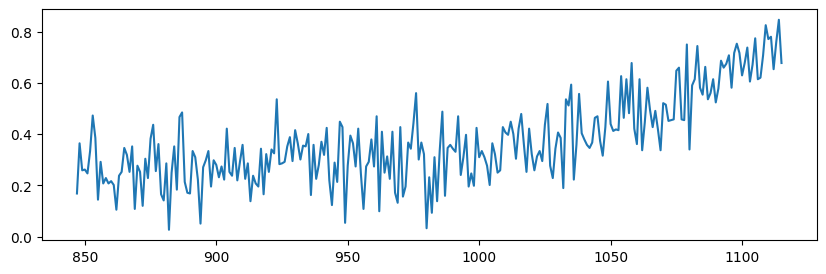

In [29]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<Axes: >

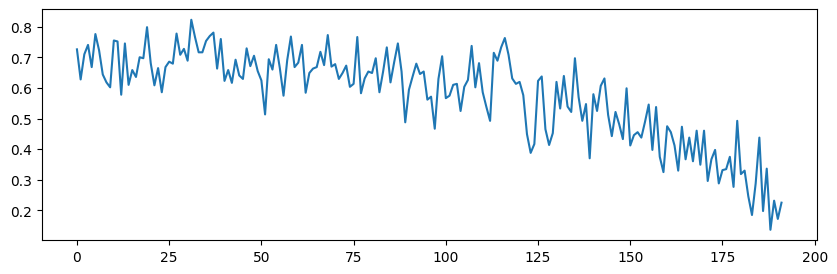

In [30]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing Time duration.

<Axes: >

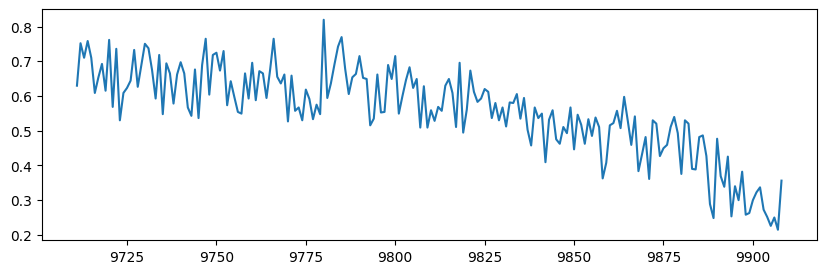

In [31]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing time duration.

We can sew that when the sensor values approach a particular value, the Engine may fail to work soon.

# 5. Generating Input Sequence


In [32]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [33]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [34]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [35]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array.

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label.
    return label_array[seq_length:num_elements, :]

In [36]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1'])
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

# 6. RNN Models
We will build, train, and evaluate the following models:

* Simple RNN [25 Features] <br>
* Bi-Directional RNN [25 Features] <br>

**Model Evaluation on the Train and Validation Sets**

In [37]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):

  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

**Training Curve**

In [38]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

**Model Evaluation on the Train Set**

In [40]:
def analyze_model_on_train_set(input_sequence_set, model_name):

  # The training metrics are as follows:
  model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
  print('Train Accurracy: {}'.format(model_history_scores[1]))

  # Make predictions and compute the confusion matrix.
  y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
  y_true = label_set

  test_set = pd.DataFrame(y_pred)
  test_set.to_csv('binary_submit_train.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_cm = confusion_matrix(y_true, y_pred)
  print(model_cm)

  # Compute the precision and recall.
  model_precision = precision_score(y_true, y_pred)
  model_recall = recall_score(y_true, y_pred)
  print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)



**Model evaluation on test set**

In [50]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
  # We will consider all the last sequences of the test set.
  last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:]
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
  last_test_seq = np.asarray(last_test_seq).astype(np.float32)

  # Get the labels of the test set.
  y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
  last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
  last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

  # If the best model weights were saved, load them.
  if os.path.isfile(model_path):
    print("using " + model_path)
    model_estimator = load_model(model_path)
  model_estimator = load_model(model_path)
  # Test the metrics.
  start = time.time()
  scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
  end = time.time()
  print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

  print('Test Accurracy: {}'.format(scores_test[1]))

  # Make predictions and compute the confusion matrix.
  y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
  y_true_test = last_test_label

  test_set = pd.DataFrame(y_model_estimator_pred_test)
  test_set.to_csv('binary_submit_test.csv', index = None)

  print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
  model_estimator_conf_m = confusion_matrix(y_true_test, y_model_estimator_pred_test)
  print(model_estimator_conf_m)

  # Compute the precision and recall values.
  model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
  model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
  f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
  print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

  # Plot the predicted data in blue and the
  # actual data in green to visually verify the accuracy of the model.
  fig_verify = plt.figure(figsize=(10, 5))
  plt.plot(y_model_estimator_pred_test, color="blue")
  plt.plot(y_true_test, color="green")
  plt.title('prediction')
  plt.ylabel('value')
  plt.xlabel('row')
  plt.legend(['predicted', 'actual data'], loc='upper left')
  plt.show()

## 6.1 Simple RNN With 25 Features
Let's now consider data from all 21 sensors and 3 settings as well.
This will lead to 25 features in the input sequence set.

In [42]:
# Pick the feature columns.
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'Hrs_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [43]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [44]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))

RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/content/sample_data'

Features dimension:  25
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 5)             155       
                                                                 
 dropout (Dropout)           (None, 50, 5)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
Total params: 186 (744.00 Byte)
Trainable params: 186 (744.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_______________________________________

In [45]:
import time
epochs = 20
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/20
75/75 - 17s - loss: 0.5049 - accuracy: 0.7690 - val_loss: 0.3680 - val_accuracy: 0.8811 - 17s/epoch - 224ms/step
Epoch 2/20
75/75 - 9s - loss: 0.3465 - accuracy: 0.8766 - val_loss: 0.3002 - val_accuracy: 0.8990 - 9s/epoch - 116ms/step
Epoch 3/20
75/75 - 8s - loss: 0.2814 - accuracy: 0.8974 - val_loss: 0.2479 - val_accuracy: 0.9182 - 8s/epoch - 104ms/step
Epoch 4/20
75/75 - 9s - loss: 0.2460 - accuracy: 0.9313 - val_loss: 0.2351 - val_accuracy: 0.9182 - 9s/epoch - 116ms/step
Epoch 5/20
75/75 - 9s - loss: 0.2268 - accuracy: 0.9381 - val_loss: 0.2058 - val_accuracy: 0.9271 - 9s/epoch - 121ms/step
Epoch 6/20
75/75 - 8s - loss: 0.2120 - accuracy: 0.9386 - val_loss: 0.1990 - val_accuracy: 0.9335 - 8s/epoch - 111ms/step
Epoch 7/20
75/75 - 8s - loss: 0.1980 - accuracy: 0.9417 - val_loss: 0.1897 - val_accuracy: 0.9348 - 8s/epoch - 110ms/step
Epoch 8/20
75/75 - 10s - loss: 0.1919 - accuracy: 0.9402 - val_loss: 0.1855 - val_accuracy: 0.9386 - 10s/epoch - 131ms/step
Epoch 9/20
75/75 - 9

**Plot Model Accuracy for the Train and Validation Sets**

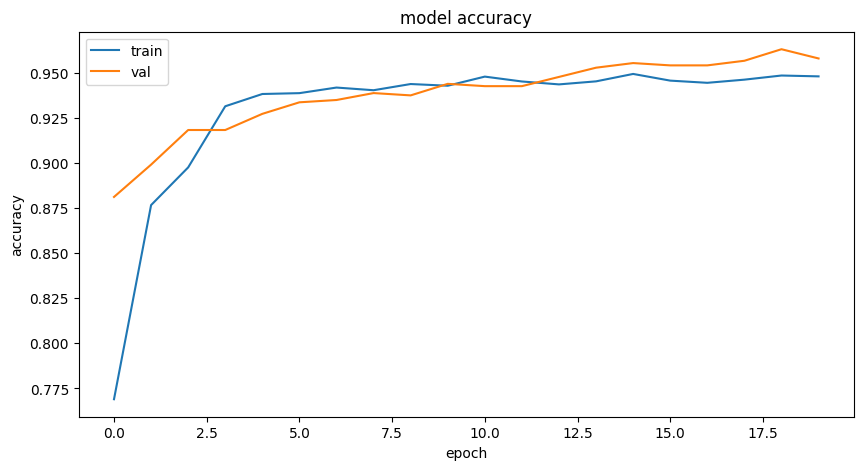

In [46]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

**Training Curve**

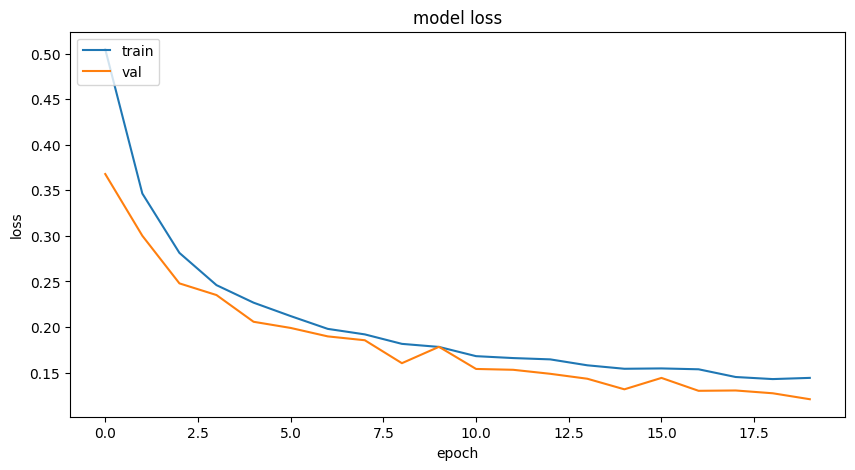

In [47]:
plot_training_curve(RNN_fwd_2_history,10,5)

**Model Evaluation on Train Set**

In [48]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

313/313 [==============================] - 4s 12ms/step - loss: 0.1141 - accuracy: 0.9545
Train Accurracy: 0.9545134902000427
79/79 [==============================] - 1s 9ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[12677   454]
 [  257  2243]]
Train Precision =  0.8316648127549129 
 Train Recall =  0.8972


**Model Evaluation on Test Set**

3/3 - 0s - loss: 0.1654 - accuracy: 0.9355 - 277ms/epoch - 92ms/step
Total time taken for inferencing:  0.32  secs
Test Accurracy: 0.9354838728904724
3/3 [==============================] - 0s 11ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[71  3]
 [ 3 16]]
Test Precision:  0.8421052631578947 
 Test Recall:  0.8421052631578947 
 Test F1-score: 0.8421052631578947


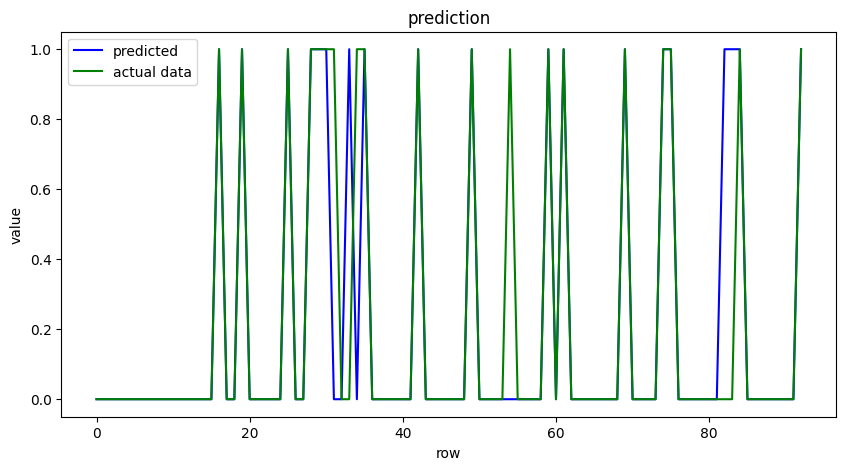

In [51]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

## 6.3 Bidirectional RNN

You saw how to build ForwardRNN models with SimpleRNN units.

Let's now create a bidirectional RNN model.


In [52]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()

# Understanding return_sequences and the connection across RNN layers
# Note that we have to return the sequence from the first layer so the next layer can get the sequence.

RNN_bi.add(Bidirectional( #We need to pass the RNN unit as an argument of the Bidirectional() function.
         SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=6,
         return_sequences=True)))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_bi.add(Dropout(0.2))

RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = '/content/sample_data'

Features dimension:  25
Output dimension:  1


In [53]:
import time
epochs = 20
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")



Epoch 1/20
75/75 - 17s - loss: 0.5438 - accuracy: 0.7820 - val_loss: 0.4560 - val_accuracy: 0.8402 - 17s/epoch - 222ms/step
Epoch 2/20
75/75 - 13s - loss: 0.4846 - accuracy: 0.8191 - val_loss: 0.4016 - val_accuracy: 0.8402 - 13s/epoch - 174ms/step
Epoch 3/20
75/75 - 15s - loss: 0.4080 - accuracy: 0.8329 - val_loss: 0.3094 - val_accuracy: 0.8402 - 15s/epoch - 195ms/step
Epoch 4/20
75/75 - 16s - loss: 0.3247 - accuracy: 0.8571 - val_loss: 0.2733 - val_accuracy: 0.8402 - 16s/epoch - 208ms/step
Epoch 5/20
75/75 - 12s - loss: 0.2900 - accuracy: 0.8698 - val_loss: 0.2547 - val_accuracy: 0.8414 - 12s/epoch - 166ms/step
Epoch 6/20
75/75 - 13s - loss: 0.2724 - accuracy: 0.8958 - val_loss: 0.2446 - val_accuracy: 0.9118 - 13s/epoch - 167ms/step
Epoch 7/20
75/75 - 12s - loss: 0.2561 - accuracy: 0.9111 - val_loss: 0.2265 - val_accuracy: 0.9220 - 12s/epoch - 159ms/step
Epoch 8/20
75/75 - 12s - loss: 0.2456 - accuracy: 0.9181 - val_loss: 0.2148 - val_accuracy: 0.9233 - 12s/epoch - 166ms/step
Epoch 9/

In [54]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 50, 12)            384       
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 50, 12)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 3)                 48        
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 436 (1.70 KB)
Trainable params: 436 (1.70 KB)
Non-trainable params: 0 (0.00 Byte)
________________________

**Plot model accuracy for train and validation set**

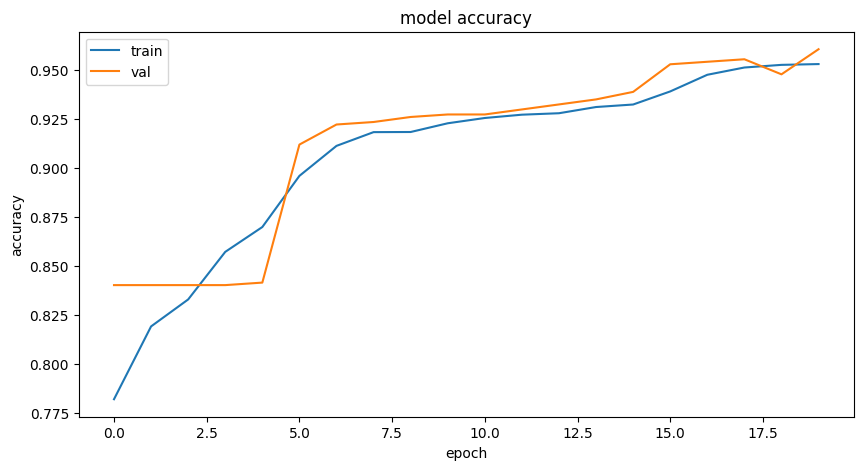

In [55]:
plot_model_accuracy(RNN_bi_history,10,5)

**Training curve**

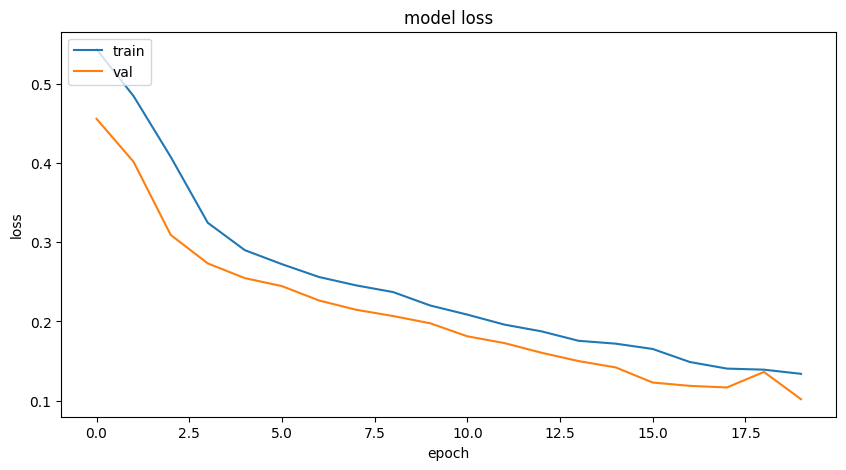

In [56]:
plot_training_curve(RNN_bi_history,10,5)

**Model Evaluation on train set**

In [57]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

313/313 [==============================] - 5s 16ms/step - loss: 0.1039 - accuracy: 0.9577
Train Accurracy: 0.9577122330665588
79/79 [==============================] - 1s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[13019   112]
 [  549  1951]]
Train Precision =  0.9457101308773631 
 Train Recall =  0.7804


**Model Evaluation on test set**

3/3 - 1s - loss: 0.1701 - accuracy: 0.9462 - 600ms/epoch - 200ms/step
Total time taken for inferencing:  0.73  secs
Test Accurracy: 0.9462365508079529
3/3 [==============================] - 0s 13ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[73  1]
 [ 4 15]]
Test Precision:  0.9375 
 Test Recall:  0.7894736842105263 
 Test F1-score: 0.8571428571428572


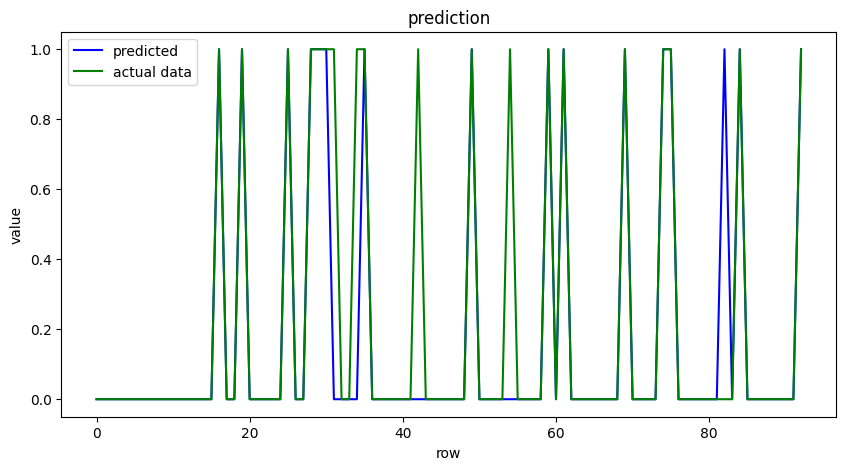

In [58]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

### RNN Summary
1. RNN model with all 25 features achieves better accuracy and other evaluation metrics
2. When we use more than one layer, the previous layer must be set to return_sequences = True.

# 7. Model Building with LSTM

In [59]:
# Model - (100 LSTM units with 0.2 dropout) +
#         (50 LSTM units with 0.2 dropout) +
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

model = Sequential()

# Understanding of return_sequences and connection across LSTM layers
model.add(LSTM(
         input_shape=(sequence_length, features_dim),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# Define path to save model
model_path = '/content/sample_data'

Features dimension:  25
Output dimension:  1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout_4 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80651 (315.04 KB)
Trainable params: 80651 (315.04 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________

In [60]:
import time
epochs = 20
batch_size = 200
start = time.time()

# Fit the network
history = model.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/20
75/75 - 16s - loss: 0.2596 - accuracy: 0.8911 - val_loss: 0.1196 - val_accuracy: 0.9501 - 16s/epoch - 216ms/step
Epoch 2/20
75/75 - 7s - loss: 0.0897 - accuracy: 0.9656 - val_loss: 0.0990 - val_accuracy: 0.9527 - 7s/epoch - 88ms/step
Epoch 3/20
75/75 - 7s - loss: 0.0740 - accuracy: 0.9690 - val_loss: 0.0494 - val_accuracy: 0.9808 - 7s/epoch - 90ms/step
Epoch 4/20
75/75 - 1s - loss: 0.0717 - accuracy: 0.9706 - val_loss: 0.0638 - val_accuracy: 0.9680 - 723ms/epoch - 10ms/step
Epoch 5/20
75/75 - 1s - loss: 0.0693 - accuracy: 0.9724 - val_loss: 0.0723 - val_accuracy: 0.9655 - 610ms/epoch - 8ms/step
Epoch 6/20
75/75 - 7s - loss: 0.0589 - accuracy: 0.9756 - val_loss: 0.0485 - val_accuracy: 0.9821 - 7s/epoch - 98ms/step
Epoch 7/20
75/75 - 6s - loss: 0.0598 - accuracy: 0.9741 - val_loss: 0.0452 - val_accuracy: 0.9808 - 6s/epoch - 81ms/step
Epoch 8/20
75/75 - 1s - loss: 0.0554 - accuracy: 0.9755 - val_loss: 0.0540 - val_accuracy: 0.9834 - 720ms/epoch - 10ms/step
Epoch 9/20
75/75 - 1s

**Model Evaluation on Validation set**


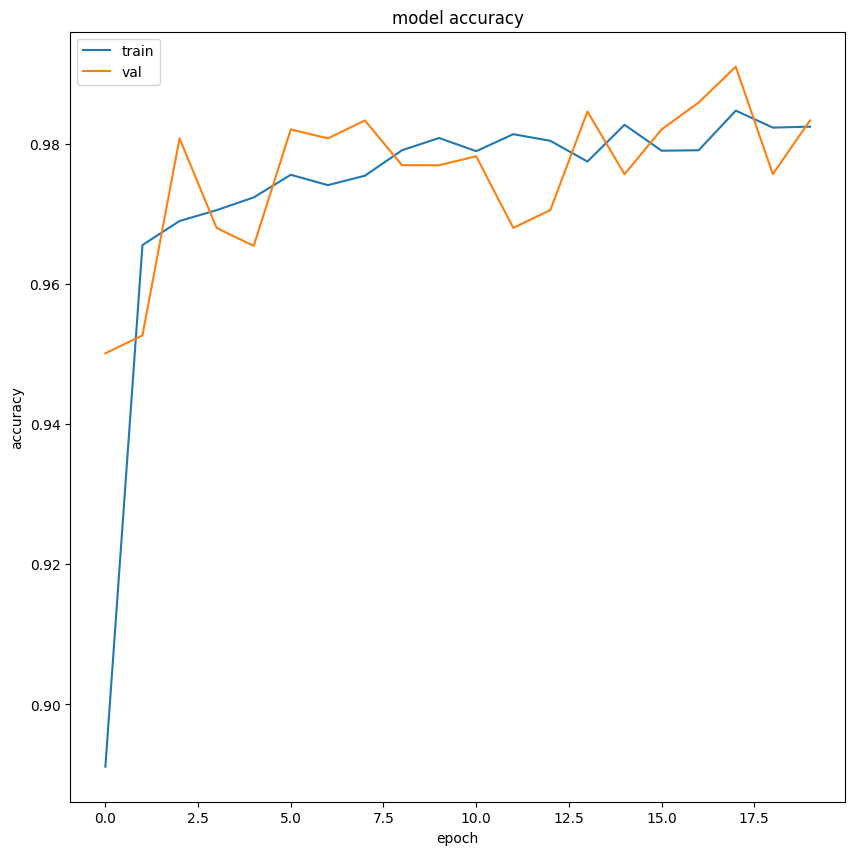

In [61]:
# Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

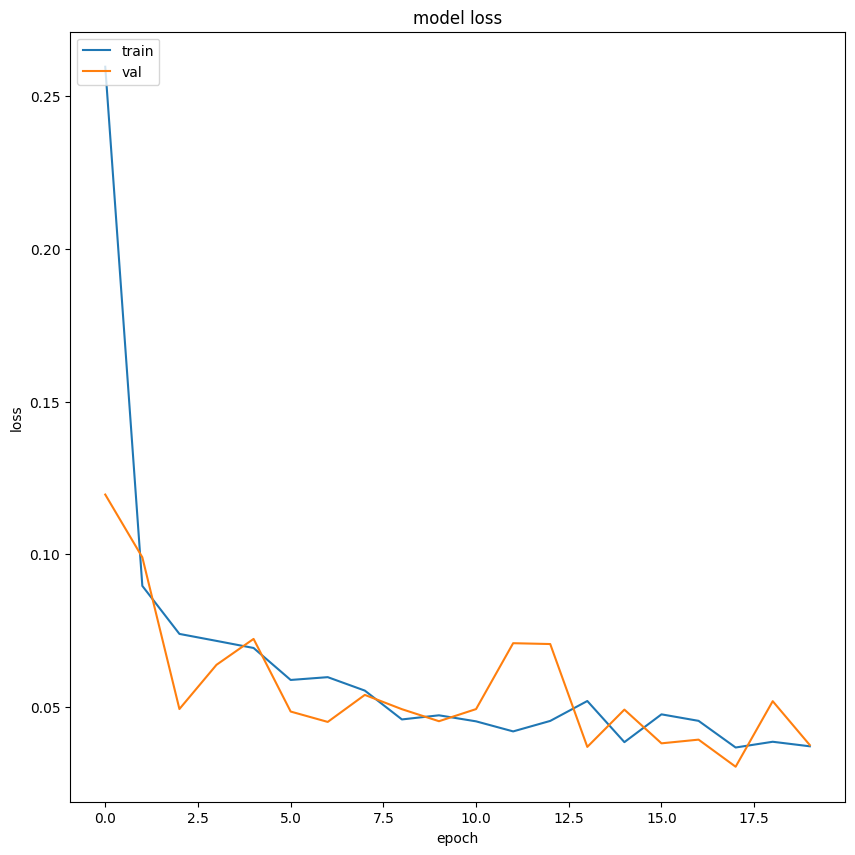

In [62]:
# Plot model loss for train and test sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
# Training metrics
scores = model.evaluate(seq_set_f25, label_set, verbose=1, batch_size=50)
print('Train Accurracy: {}'.format(scores[1]))

# Make predictions and compute confusion matrix
y_pred = (model.predict(seq_set_f25, verbose=1, batch_size=200) > 0.5).astype("int32")
y_true = label_set

test_set = pd.DataFrame(y_pred)
test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Compute precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
print( 'Train Precision = ', precision, '\n', 'Train Recall = ', recall)

313/313 [==============================] - 1s 5ms/step - loss: 0.0393 - accuracy: 0.9823
Train Accurracy: 0.9822788238525391
79/79 [==============================] - 1s 4ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[13114    17]
 [  260  2240]]
Train Precision =  0.9924678777137793 
 Train Recall =  0.896


**Model Evaluation on Test set**

3/3 - 1s - loss: 0.0560 - accuracy: 0.9785 - 698ms/epoch - 233ms/step
Total time taken for inferencing:  0.74  secs
Test Accurracy: 0.9784946441650391
3/3 [==============================] - 1s 6ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[72  2]
 [ 0 19]]
Test Precision:  0.9047619047619048 
 Test Recall:  1.0 
 Test F1-score: 0.9500000000000001


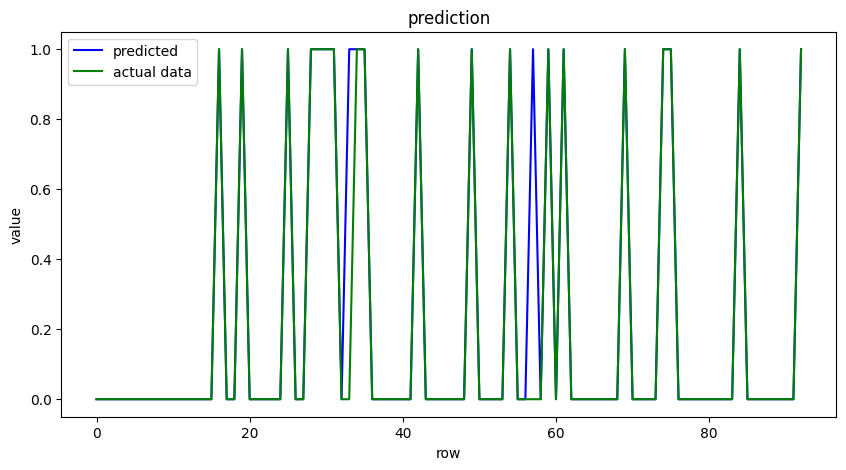

In [65]:
# Considering all the last sequences of test set
last_test_seq = [test_df[test_df['id']==id][sequence_cols_25].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
last_test_seq = np.asarray(last_test_seq).astype(np.float32)

# Get labels of test set
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

# If best model weights were saved then load it
if os.path.isfile(model_path):
    estimator = load_model(model_path)
estimator = load_model(model_path)
# Test metrics
start = time.time()
scores_test = estimator.evaluate(last_test_seq, last_test_label, verbose=2)
end = time.time()
print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

print('Test Accurracy: {}'.format(scores_test[1]))

# Make predictions and compute confusion matrix
y_pred_test = (estimator.predict(last_test_seq) > 0.5).astype("int32")
y_true_test = last_test_label

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('binary_submit_test.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
conf_m = confusion_matrix(y_true_test, y_pred_test)
print(conf_m)

# Compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test)
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test,'\n', 'Test F1-score:', f1_test )

# Plot in blue color the predicted data and in green color the
# Actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

The LSTM model was trained on a dataset from mining machines to predict breakdowns using sensor values. Here's a summary of the key results:

1. Model Architecture:
   - Features Dimension: 25
   - Output Dimension: 1
   - The model architecture consists of two LSTM layers with dropout layers in between and a final dense layer.
   - The first LSTM layer has 100 units.
   - The second LSTM layer has 50 units.
   - The dropout layers were used to prevent overfitting.
   - The model has a total of 80,651 trainable parameters.

2. Training Results:
   - Training Accuracy: 98.23%
   - The model achieved high accuracy on the training data, indicating its ability to learn and predict breakdowns.

3. Confusion Matrix (Training Data):
   - True Positives: 13,114
   - False Positives: 17
   - False Negatives: 260
   - True Negatives: 2,240
   - Training Precision: 99.25%
   - Training Recall: 89.6%

4. Test Results:
   - Test Accuracy: 97.85%
   - The model also performed well on the test data, showing its ability to generalize to new data.

5. Confusion Matrix (Test Data):
   - True Positives: 72
   - False Positives: 2
   - False Negatives: 0
   - True Negatives: 19
   - Test Precision: 90.48%
   - Test Recall: 100%
   - Test F1-Score: 95.00%

Overall, the LSTM model demonstrated strong performance in predicting breakdowns in mining machines based on sensor data, achieving high accuracy and a good balance between precision and recall on both the training and test datasets.